Trial 180 Complete [00h 00m 05s]
val_loss: 106211827712.0

Best val_loss So Far: 1956939008.0
Total elapsed time: 00h 05m 09s
7/7 [==============================] - 0s 4ms/step - loss: 2779609088.0000
Best Model Test Loss: 2779609088.0
7/7 [==============================] - 0s 0s/step


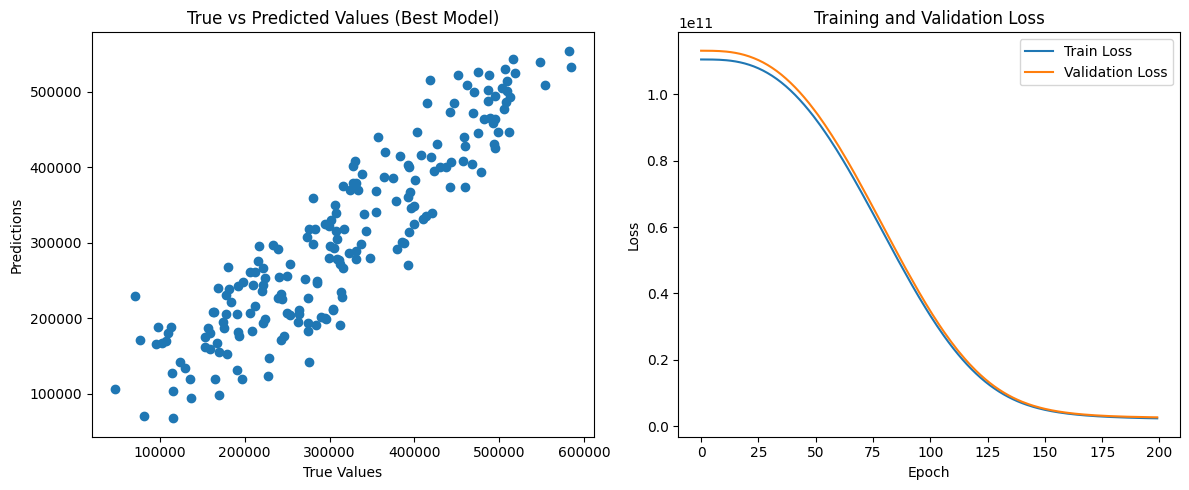

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
import pandas as pd

# Load data
data = pd.read_csv('train.csv')
x = data.iloc[:, 3:11]
y = data.iloc[:, -1]

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

# Normalize data
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)  # Use transform, not fit_transform

# Define and compile the initial model
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    x_train_normalized,
    y_train,
    epochs=200,
    validation_data=(x_test_normalized, y_test),
    batch_size=32,
    verbose=1
)

# Evaluate the model
loss = model.evaluate(x_test_normalized, y_test)
print(f"Initial Model Test Loss: {loss}")

# Predict
y_pred = model.predict(x_test_normalized)

# Plot results
plt.figure(figsize=(12, 5))

# Scatter plot of true vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Define the hyperparameter tuning function
def build_model(hp):
    model = Sequential([
        Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu', input_shape=(x_train.shape[1],)),
        Dense(hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error'
    )
    return model

# Set up the hyperparameter tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    hyperband_iterations=2,
    directory='kt_dir',
    project_name='car_price'
)

# Perform the hyperparameter search
tuner.search(x_train_normalized, y_train, epochs=50, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss = best_model.evaluate(x_test_normalized, y_test)
print(f"Best Model Test Loss: {loss}")

# Predict with the best model
y_pred_best = best_model.predict(x_test_normalized)

# Plot results for the best model
plt.figure(figsize=(12, 5))

# Scatter plot of true vs predicted values for the best model
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values (Best Model)')

# Plot training and validation loss for the best model
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                864       
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________
